# Bài toán 1: Dự đoán Giá Nhà sử dụng Machine Learning

## Mục tiêu
Xây dựng mô hình Machine Learning để dự đoán giá nhà dựa trên các đặc điểm như diện tích, số phòng, vị trí địa lý, và các yếu tố khác.

## Dataset
- File: `data/house_dataset.csv`
- Features: 28 cột bao gồm price, area, rooms, toilets, floors, location, etc.

## Workflow
1. Import thư viện và load data
2. Data Preprocessing & Feature Engineering
3. Model Training (Linear Regression, Random Forest, XGBoost, ...)
4. Model Evaluation & Comparison
5. Feature Importance Analysis

---

## 1. Import Libraries

In [198]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
import lightgbm as lgb

# Model persistence
import joblib
from datetime import datetime
import time

# Cấu hình hiển thị
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## 2. Load Dataset và Khám phá ban đầu

In [199]:
# Load dataset (sử dụng cleaned data nếu có, nếu không thì dùng original)
import os

df = pd.read_csv('data/house_dataset.csv')

# Thông tin cơ bản

print("THÔNG TIN DATASET")

print(f"Số dòng: {df.shape[0]:,}")
print(f"Số cột: {df.shape[1]}")
print(f"Kích thước: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("5 DÒNG ĐẦU TIÊN")
df.head()

THÔNG TIN DATASET
Số dòng: 10,044
Số cột: 28
Kích thước: 22.81 MB
5 DÒNG ĐẦU TIÊN


,id,title,price,area,date,city,district,ward,street,lat,lng,body,rooms,toilets,floors,legal,seller_type,protection,image_count,image_thumb,width,length,pty_characteristics,owner_type,is_pro,verified,page,dateFormatted
0,172448163,BÁN NHÀ NGỌC THUỴ 5 TẦNG XÂY ĐẸP - NGÕ Ô TÔ ĐỖ...,7500000000,40.0,1766120565000,Hà Nội,Quận Long Biên,Phường Ngọc Thụy,Đường Ngọc Thụy,21.059816,105.863655,"- diện tích 40m2 \r\n- Bán nhà 5 tầng, full nộ...",3.0,4.0,5.0,1.0,True,False,8,https://cdn.chotot.com/eyVUiVEYyKCf7vUjZ-0tHD9...,NaN,NaN,"[2, 3]",True,True,False,0,2025-12-19
1,171753972,"7,78tỷ, 123m2, 3PN CĂN GÓC CC PACKEXIM Võ Chí ...",7850000000,123.0,1766120335000,Hà Nội,Quận Tây Hồ,Phường Phú Thượng,An Dương Vương,21.087900,105.814640,Cần Bán gấp căn hộ chung cư PACKEXIM Tây Hồ ch...,3.0,2.0,NaN,6.0,False,False,6,https://cdn.chotot.com/_dNyy_yK4IgDsdQNJ6RYSRU...,NaN,NaN,[],NaN,False,False,0,2025-12-19
2,173047043,NHÀ BIÊN GIANG HÀ ĐÔNG - 38M2 X 5 TẦNG - Ô TÔ ...,5200000000,38.0,1766120222000,Hà Nội,Quận Hà Đông,Phường Biên Giang,Quốc Lộ 6,20.928316,105.721920,NHÀ BIÊN GIANG HÀ ĐÔNG - 38M2 X 5 TẦNG - Ô TÔ ...,3.0,NaN,NaN,1.0,True,False,12,https://cdn.chotot.com/D2-PV3NvYtwqX9s0TaWFNlq...,NaN,NaN,[],True,True,False,0,2025-12-19
3,173047018,BÁN NHÀ NGÕ 141 NAM DƯ – LĨNH NAM | DÒNG TIỀN ...,9200000000,46.0,1766120209000,Hà Nội,Quận Hoàng Mai,Phường Lĩnh Nam,Phố Nam Dư,20.985332,105.888290,BÁN NHÀ NGÕ 141 NAM DƯ – LĨNH NAM | DÒNG TIỀN ...,7.0,6.0,5.0,1.0,False,False,12,https://cdn.chotot.com/EfgTJ3Ven-Hth37N72joEgw...,5.0,9.5,[2],NaN,False,False,0,2025-12-19
4,172448699,"BÁN GẤP NHÀ ĐẸP HOA LÂM - Ô TÔ ĐỖ CỬA , VÀI BƯ...",6000000000,33.0,1766119664000,Hà Nội,Quận Long Biên,Phường Đức Giang,hoa lâm,21.059334,105.894620,hiện tại do công tác nơi xa nên chủ nhà thiện ...,3.0,4.0,5.0,1.0,True,False,11,https://cdn.chotot.com/GmW4V4YludkDiXxX9CK7QcL...,NaN,NaN,[],True,True,False,0,2025-12-19


In [200]:
# Lọc dữ liệu
print("DATA CLEANING - LOẠI BỎ OUTLIERS")

# Số dòng ban đầu
n_before = len(df)

# 1. Loại bỏ nhà có số tầng > 10 
df = df[(df['floors'] <= 10) | (df['floors'].isna())]
n_after_floors = len(df)
print(f"\nDelete floors > 10: {n_after_floors:,} ({n_before - n_after_floors:,} rows deleted)")

# 2. Loại bỏ outliers của area theo IQR
Q1 = df['area'].quantile(0.25)
Q3 = df['area'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nArea IQR Analysis:")
print(f"  Q1: {Q1:.2f}")
print(f"  Q3: {Q3:.2f}")
print(f"  IQR: {IQR:.2f}")
print(f"  Lower bound: {lower_bound:.2f}")
print(f"  Upper bound: {upper_bound:.2f}")

df = df[((df['area'] >= lower_bound) & (df['area'] <= upper_bound)) | (df['area'].isna())]
n_final = len(df)
print(f"\nRow based on area: {n_final:,} ({n_after_floors - n_final:,} rows deleted)")

print(f"\nDeleted rows: {n_before - n_final:,} ({(n_before - n_final)/n_before*100:.2f}%)")
print(f"Remaining rows: {n_final:,}")

DATA CLEANING - LOẠI BỎ OUTLIERS

Delete floors > 10: 10,016 (28 rows deleted)

Area IQR Analysis:
  Q1: 37.00
  Q3: 70.00
  IQR: 33.00
  Lower bound: -12.50
  Upper bound: 119.50

Row based on area: 9,652 (364 rows deleted)

Deleted rows: 392 (3.90%)
Remaining rows: 9,652


## 3. Feature Engineering

In [201]:
df_clean = df.copy()

print("FEATURE ENGINEERING")

# Tạo các features mới
if 'rooms' in df_clean.columns and 'toilets' in df_clean.columns:
    df_clean['total_rooms'] = df_clean['rooms'].fillna(0) + df_clean['toilets'].fillna(0)
    df_clean['toilet_room_ratio'] = df_clean['toilets'] / (df_clean['rooms'] + 1)
    print("Total_rooms, toilet_room_ratio")

if 'area' in df_clean.columns and 'floors' in df_clean.columns:
    df_clean['area_per_floor'] = df_clean['area'] / (df_clean['floors'].fillna(1) + 0.1)
    df_clean['total_floor_area'] = df_clean['area'] * df_clean['floors'].fillna(1)
    print("Area_per_floor, total_floor_area")

if 'width' in df_clean.columns and 'length' in df_clean.columns:
    df_clean['has_dimensions'] = ((df_clean['width'].notna()) & (df_clean['length'].notna())).astype(int)
    df_clean['width_length_ratio'] = df_clean['width'] / (df_clean['length'] + 0.1)
    print("Has_dimensions, width_length_ratio")

if 'lat' in df_clean.columns and 'lng' in df_clean.columns:
    center_lat, center_lng = 21.0285, 105.8542
    df_clean['distance_from_center'] = np.sqrt(
        (df_clean['lat'].fillna(center_lat) - center_lat)**2 + 
        (df_clean['lng'].fillna(center_lng) - center_lng)**2
    )
    print("Distance_from_center")

if 'total_rooms' in df_clean.columns and 'area' in df_clean.columns:
    df_clean['rooms_per_sqm'] = df_clean['total_rooms'] / (df_clean['area'] + 1)
    print("Rooms_per_sqm")
print(f"\nTotal features: {df_clean.shape[1]}")

FEATURE ENGINEERING
Total_rooms, toilet_room_ratio
Area_per_floor, total_floor_area
Has_dimensions, width_length_ratio
Distance_from_center
Rooms_per_sqm

Total features: 36


In [202]:
# Chọn features cho model
# Features số
numeric_features = [
    'area', 'rooms', 'toilets', 'floors', 'lat', 'lng',
    'width', 'length',
    'total_rooms', 'toilet_room_ratio', 'area_per_floor', 
    'has_dimensions', 'distance_from_center', 'width_length_ratio',
    'total_floor_area', 'rooms_per_sqm'
]

# Features phân loại
categorical_features = [
    'district', 'ward', 'legal', 'seller_type', 'owner_type', 'city', 'street', 'protection'
]

print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Xử lý missing values cho numeric features
for col in numeric_features:
    if df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"fill {col} : {median_val:.2f}")

Numeric features (16): ['area', 'rooms', 'toilets', 'floors', 'lat', 'lng', 'width', 'length', 'total_rooms', 'toilet_room_ratio', 'area_per_floor', 'has_dimensions', 'distance_from_center', 'width_length_ratio', 'total_floor_area', 'rooms_per_sqm']
Categorical features (8): ['district', 'ward', 'legal', 'seller_type', 'owner_type', 'city', 'street', 'protection']
fill rooms : 3.00
fill toilets : 3.00
fill floors : 3.00
fill width : 4.00
fill length : 12.60
fill toilet_room_ratio : 0.67
fill width_length_ratio : 0.33


In [203]:
# Encode categorical features
label_encoders = {}

for col in categorical_features:
    if col in df_clean.columns:
        # Fill missing values với 'Unknown'
        df_clean[col] = df_clean[col].fillna('Unknown')
        
        # Label encoding
        le = LabelEncoder()
        df_clean[col + '_encoded'] = le.fit_transform(df_clean[col].astype(str))
        label_encoders[col] = le
        
        print(f"Encoded {col}: {len(le.classes_)} unique values")

# Update numeric features list
numeric_features_final = numeric_features + [col + '_encoded' for col in categorical_features if col in df_clean.columns]

print(f"\nTotal features for model: {len(numeric_features_final)}")

Encoded district: 50 unique values
Encoded ward: 462 unique values
Encoded legal: 7 unique values
Encoded seller_type: 2 unique values
Encoded owner_type: 2 unique values
Encoded city: 2 unique values
Encoded street: 2953 unique values
Encoded protection: 2 unique values

Total features for model: 24


## 5. Train-Test Split & Feature Scaling

In [204]:
# Chuẩn bị dữ liệu cho model
X = df_clean[numeric_features_final].copy()
y = df_clean['price'].copy()

# Kiểm tra và xử lý inf values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print("TRAIN-TEST SPLIT")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Split data (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures đã được scale bằng StandardScaler")

TRAIN-TEST SPLIT
X shape: (9652, 24)
y shape: (9652,)

Training set: 7,721 samples
Test set: 1,931 samples

Features đã được scale bằng StandardScaler


## 5.1. Hyperparameter Tuning - Random Search

In [205]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

print("HYPERPARAMETER TUNING")

# Define parameter distributions for each model
param_distributions = {
    'Random Forest': {
        'n_estimators': randint(50, 200),
        'max_depth': randint(10, 30),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
    },
    'XGBoost': {
        'n_estimators': randint(100, 300),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.2),
        'subsample': uniform(0.7, 0.3),
        'colsample_bytree': uniform(0.7, 0.3),
    },
    'LightGBM': {
        'n_estimators': randint(100, 300),
        'max_depth': randint(5, 15),
        'learning_rate': uniform(0.01, 0.2),
        'num_leaves': randint(30, 100),
        'subsample': uniform(0.7, 0.3),
    },
    'Gradient Boosting': {
        'n_estimators': randint(50, 200),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.2),
        'subsample': uniform(0.7, 0.3),
    },
    'Decision Tree': {
        'max_depth': randint(10, 30),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
    }
}

base_models = {
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}

best_params = {}

# Perform RandomizedSearchCV for each model
for name, model in base_models.items():
    print(f"\nTuning {name}...")
    
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions[name],
        n_iter=20,  # Number of parameter settings sampled
        cv=3,  # 3-fold cross-validation
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    random_search.fit(X_train_scaled, y_train)
    
    best_params[name] = random_search.best_params_
    
    print(f"   Best Score (MAE): {-random_search.best_score_:,.0f} VNĐ")
    print(f"   Best Params: {random_search.best_params_}")

print("BEST PARAMETERS FOUND")

for name, params in best_params.items():
    print(f"\n{name}:")
    for param, value in params.items():
        print(f"   {param}: {value}")

HYPERPARAMETER TUNING

Tuning Random Forest...
   Best Score (MAE): 814,873,101 VNĐ
   Best Params: {'max_depth': 21, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 108}

Tuning XGBoost...
   Best Score (MAE): 773,022,763 VNĐ
   Best Params: {'colsample_bytree': np.float64(0.8184644554526709), 'learning_rate': np.float64(0.06869763494360763), 'max_depth': 9, 'n_estimators': 238, 'subsample': np.float64(0.7596527212266415)}

Tuning LightGBM...
   Best Score (MAE): 786,275,248 VNĐ
   Best Params: {'learning_rate': np.float64(0.07530815376116708), 'max_depth': 11, 'n_estimators': 289, 'num_leaves': 69, 'subsample': np.float64(0.9533601546034454)}

Tuning Gradient Boosting...
   Best Score (MAE): 798,565,853 VNĐ
   Best Params: {'learning_rate': np.float64(0.1594640220274762), 'max_depth': 9, 'n_estimators': 102, 'subsample': np.float64(0.8760253496991544)}

Tuning Decision Tree...
   Best Score (MAE): 988,376,026 VNĐ
   Best Params: {'max_depth': 11, 'min_samples_leaf': 4,

## 6. Model Training & Evaluation

In [206]:
# Định nghĩa models với best parameters từ Random Search
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(
        max_depth=11,
        min_samples_leaf=4,
        min_samples_split=5,
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        learning_rate=0.1594640220274762,
        max_depth=9,
        n_estimators=102,
        subsample=0.8760253496991544,
        random_state=42
    ),
    'Random Forest': RandomForestRegressor(
        max_depth=21,
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=108,
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': xgb.XGBRegressor(
        colsample_bytree=0.8184644554526709,
        learning_rate=0.06869763494360763,
        max_depth=9,
        n_estimators=238,
        subsample=0.7596527212266415,
        random_state=42,
        n_jobs=-1
    ),
    'LightGBM': lgb.LGBMRegressor(
        learning_rate=0.07530815376116708,
        max_depth=11,
        n_estimators=289,
        num_leaves=69,
        subsample=0.9533601546034454,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
}

In [207]:
# Train và evaluate các models
results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict on test set only
    y_test_pred = model.predict(X_test_scaled)
    
    # Evaluate on test set
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    
    results.append({
        'Model': name,
        'Test MAE': test_mae,
        'Test RMSE': test_rmse,
        'Test R²': test_r2
    })
    
    print(f"{name}: MAE={test_mae:,.0f} | RMSE={test_rmse:,.0f} | R²={test_r2:.4f}\n")

# Create results dataframe - Sort by Test MAE (thấp nhất = tốt nhất)
results_df = pd.DataFrame(results).sort_values('Test MAE', ascending=True)

print("MODEL COMPARISON RESULTS (Sorted by Test MAE)")

print(results_df.to_string(index=False))
print(f"\nBest model (lowest test loss): {results_df.iloc[0]['Model']}")
print(f"Best Test MAE: {results_df.iloc[0]['Test MAE']:,.0f} VNĐ ({results_df.iloc[0]['Test MAE']/1e9:.2f} tỷ)")

Training Linear Regression...
Linear Regression: MAE=1,094,744,002 | RMSE=1,406,298,313 | R²=0.5062

Training Decision Tree...
Decision Tree: MAE=935,222,062 | RMSE=1,260,596,243 | R²=0.6032

Training Gradient Boosting...
Gradient Boosting: MAE=763,105,072 | RMSE=1,038,859,179 | R²=0.7305

Training Random Forest...
Random Forest: MAE=780,984,171 | RMSE=1,059,904,295 | R²=0.7195

Training XGBoost...
XGBoost: MAE=729,290,880 | RMSE=991,884,864 | R²=0.7544

Training LightGBM...
LightGBM: MAE=756,078,666 | RMSE=1,010,967,616 | R²=0.7448

MODEL COMPARISON RESULTS (Sorted by Test MAE)
            Model     Test MAE    Test RMSE  Test R²
          XGBoost 7.292909e+08 9.918849e+08 0.754360
         LightGBM 7.560787e+08 1.010968e+09 0.744817
Gradient Boosting 7.631051e+08 1.038859e+09 0.730542
    Random Forest 7.809842e+08 1.059904e+09 0.719515
    Decision Tree 9.352221e+08 1.260596e+09 0.603239
Linear Regression 1.094744e+09 1.406298e+09 0.506222

Best model (lowest test loss): XGBoost
Bes

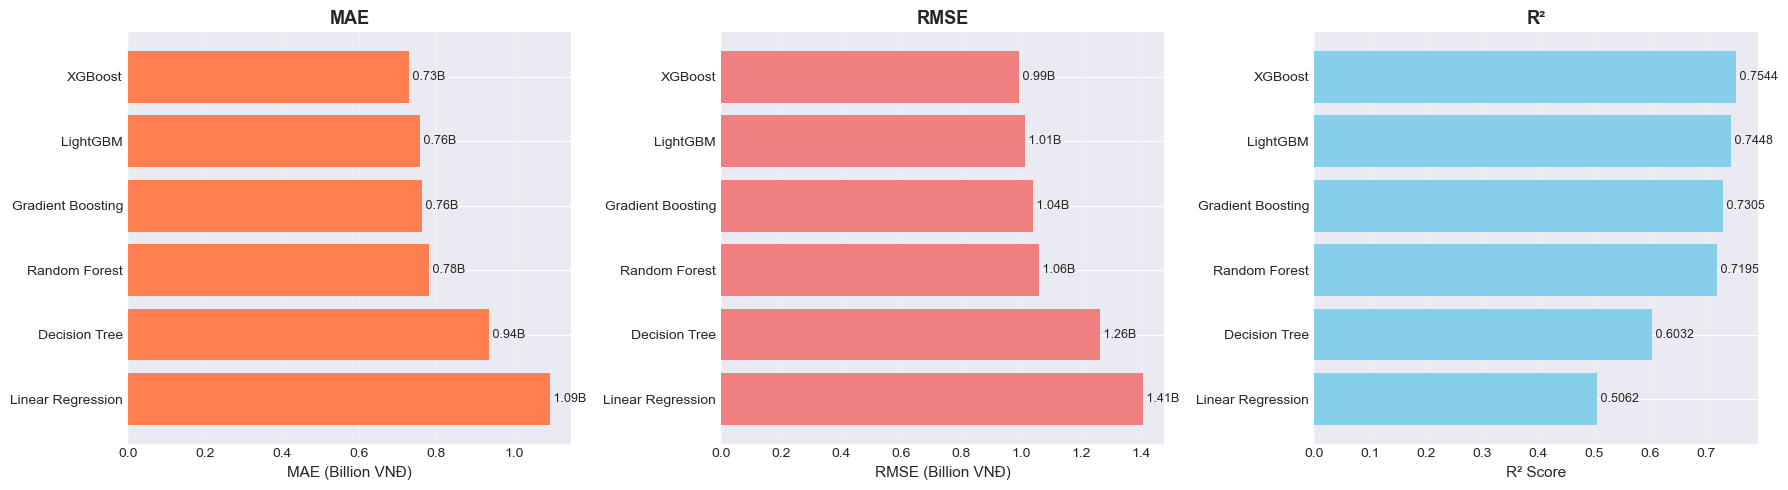

In [208]:
# Visualization: Model Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Test MAE comparison 
axes[0].barh(results_df['Model'], results_df['Test MAE']/1e9, color='coral')
axes[0].set_xlabel('MAE (Billion VNĐ)', fontsize=11)
axes[0].set_title('MAE', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()
for i, v in enumerate(results_df['Test MAE']/1e9):
    axes[0].text(v, i, f' {v:.2f}B', va='center', fontsize=9)

# Test RMSE comparison 
axes[1].barh(results_df['Model'], results_df['Test RMSE']/1e9, color='lightcoral')
axes[1].set_xlabel('RMSE (Billion VNĐ)', fontsize=11)
axes[1].set_title('RMSE', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()
for i, v in enumerate(results_df['Test RMSE']/1e9):
    axes[1].text(v, i, f' {v:.2f}B', va='center', fontsize=9)

# R² Score comparison (higher is better)
axes[2].barh(results_df['Model'], results_df['Test R²'], color='skyblue')
axes[2].set_xlabel('R² Score', fontsize=11)
axes[2].set_title('R²', fontsize=13, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)
axes[2].invert_yaxis()
for i, v in enumerate(results_df['Test R²']):
    axes[2].text(v, i, f' {v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

### Ensemble Model (RF + XGBoost + LightGBM)

In [209]:
# Ensemble model: Weighted average of RF, XGBoost, and LightGBM
print("\nENSEMBLE MODEL: Random Forest + XGBoost + LightGBM")

# Get predictions from top 3 models
rf_pred = models['Random Forest'].predict(X_test_scaled)
xgb_pred = models['XGBoost'].predict(X_test_scaled)
lgbm_pred = models['LightGBM'].predict(X_test_scaled)

# Try different weighting strategies
print("\nTesting different weight combinations:\n")

weight_configs = [
    {'name': 'Equal weights', 'weights': [1/3, 1/3, 1/3]},
    {'name': 'XGBoost focus', 'weights': [0.1, 0.8, 0.1]},
    {'name': 'Inverse MAE weights', 'weights': [
        1/results_df[results_df['Model']=='Random Forest']['Test MAE'].values[0],
        1/results_df[results_df['Model']=='XGBoost']['Test MAE'].values[0],
        1/results_df[results_df['Model']=='LightGBM']['Test MAE'].values[0]
    ]}
]

# Normalize inverse MAE weights
inv_weights = weight_configs[2]['weights']
weight_configs[2]['weights'] = [w/sum(inv_weights) for w in inv_weights]

ensemble_results = []

for config in weight_configs:
    w1, w2, w3 = config['weights']
    
    # Ensemble prediction
    ensemble_pred = w1 * rf_pred + w2 * xgb_pred + w3 * lgbm_pred
    
    # Evaluate
    ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
    ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
    ensemble_r2 = r2_score(y_test, ensemble_pred)
    
    ensemble_results.append({
        'Strategy': config['name'],
        'RF_weight': w1,
        'XGB_weight': w2,
        'LGBM_weight': w3,
        'MAE': ensemble_mae,
        'RMSE': ensemble_rmse,
        'R²': ensemble_r2
    })
    
    print(f"{config['name']}:")
    print(f"   Weights: RF={w1:.3f}, XGB={w2:.3f}, LGBM={w3:.3f}")
    print(f"   MAE={ensemble_mae:,.0f} | RMSE={ensemble_rmse:,.0f} | R²={ensemble_r2:.4f}\n")

ensemble_df = pd.DataFrame(ensemble_results)

# Find best ensemble
best_ensemble = ensemble_df.loc[ensemble_df['MAE'].idxmin()]

print("\nBEST ENSEMBLE CONFIGURATION:")
print(f"   Strategy: {best_ensemble['Strategy']}")
print(f"   MAE: {best_ensemble['MAE']:,.0f} VNĐ ({best_ensemble['MAE']/1e9:.2f} tỷ)")
print(f"   RMSE: {best_ensemble['RMSE']:,.0f} VNĐ ({best_ensemble['RMSE']/1e9:.2f} tỷ)")
print(f"   R²: {best_ensemble['R²']:.4f}")

# Compare with best single model
best_single_mae = results_df.iloc[0]['Test MAE']
improvement = ((best_single_mae - best_ensemble['MAE']) / best_single_mae) * 100

print(f"\nIMPROVEMENT OVER BEST SINGLE MODEL (XGBoost):")
print(f"   MAE reduction: {best_single_mae - best_ensemble['MAE']:,.0f} VNĐ ({improvement:.2f}%)")
print(f"   {'Ensemble is better!' if improvement > 0 else 'Single model is better'}")


ENSEMBLE MODEL: Random Forest + XGBoost + LightGBM

Testing different weight combinations:

Equal weights:
   Weights: RF=0.333, XGB=0.333, LGBM=0.333
   MAE=736,723,903 | RMSE=996,965,646 | R²=0.7518

XGBoost focus:
   Weights: RF=0.100, XGB=0.800, LGBM=0.100
   MAE=728,662,702 | RMSE=989,629,077 | R²=0.7555

Inverse MAE weights:
   Weights: RF=0.322, XGB=0.345, LGBM=0.333
   MAE=736,289,386 | RMSE=996,345,828 | R²=0.7521


BEST ENSEMBLE CONFIGURATION:
   Strategy: XGBoost focus
   MAE: 728,662,702 VNĐ (0.73 tỷ)
   RMSE: 989,629,077 VNĐ (0.99 tỷ)
   R²: 0.7555

IMPROVEMENT OVER BEST SINGLE MODEL (XGBoost):
   MAE reduction: 628,178 VNĐ (0.09%)
   Ensemble is better!


## 7. Feature Importance

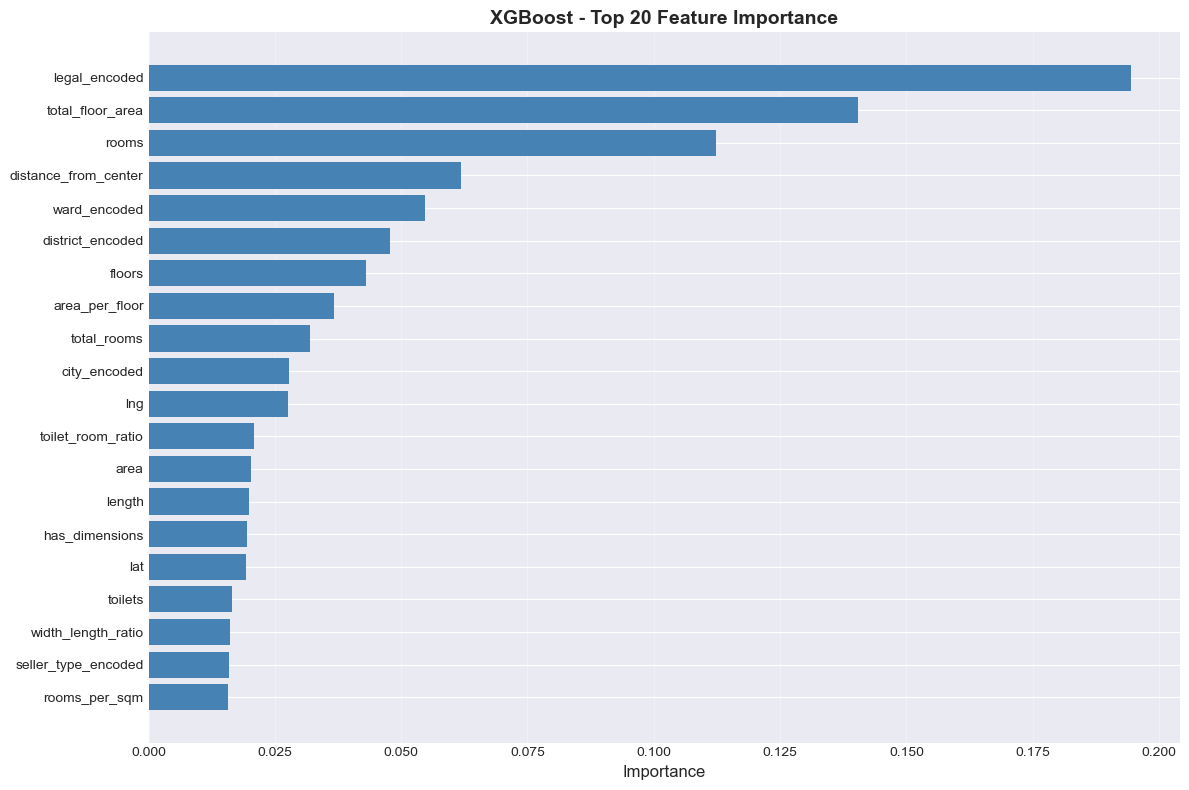

TOP 10 MOST IMPORTANT FEATURES
             Feature  Importance
       legal_encoded    0.194440
    total_floor_area    0.140333
               rooms    0.112217
distance_from_center    0.061747
        ward_encoded    0.054713
    district_encoded    0.047795
              floors    0.043074
      area_per_floor    0.036699
         total_rooms    0.031906
        city_encoded    0.027790


In [210]:
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

feature_importance = pd.DataFrame({
    'Feature': numeric_features_final,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importance)), feature_importance['Importance'], color='steelblue')
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.title(f'{best_model_name} - Top 20 Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("TOP 10 MOST IMPORTANT FEATURES")

print(feature_importance.head(10).to_string(index=False))